In [19]:
import io
from functools import lru_cache

import altair as alt
import pandas as pd
import requests

import matplotlib.pyplot as plt

In [20]:
data_url = "https://raw.githubusercontent.com/thohan88/covid19-nor-data/HEAD/data"


@lru_cache()
def download_dataset(path):
    """Download a dataset from covid19-nor-data archive"""
    url = f"{data_url}/{path}"
    print(f"Downloading {url}")
    r = requests.get(f"{data_url}/{path}")
    r.raise_for_status()
    print(f"Downloaded {len(r.content) // 1024}kB")
    return pd.read_csv(io.BytesIO(r.content), parse_dates=["date"])


all_cases = download_dataset("01_infected/msis/municipality_and_district.csv")
all_cases

Downloaded 29723kB


,date,date_time,kommune_bydel_no,kommune_bydel_name,bydel_no,bydel_name,kommune_no,kommune_name,fylke_no,fylke_name,population,cases
0,2020-03-26,2020-03-26T04:00:00Z,30101,Gamle Oslo,30101.0,Gamle Oslo,301,Oslo,3,Oslo,58671,67
1,2020-03-26,2020-03-26T04:00:00Z,30102,Grünerløkka,30102.0,Grünerløkka,301,Oslo,3,Oslo,62423,59
2,2020-03-26,2020-03-26T04:00:00Z,30103,Sagene,30103.0,Sagene,301,Oslo,3,Oslo,45089,47
3,2020-03-26,2020-03-26T04:00:00Z,30104,St. Hanshaugen,30104.0,St. Hanshaugen,301,Oslo,3,Oslo,38945,33
4,2020-03-26,2020-03-26T04:00:00Z,30105,Frogner,30105.0,Frogner,301,Oslo,3,Oslo,59269,67
...,...,...,...,...,...,...,...,...,...,...,...,...
361164,2022-10-26,2022-10-26T04:00:00Z,5442,Nesseby,NaN,NaN,5442,Nesseby,54,Troms og Finnmark,926,87
361165,2022-10-26,2022-10-26T04:00:00Z,5443,Båtsfjord,NaN,NaN,5443,Båtsfjord,54,Troms og Finnmark,2221,446
361166,2022-10-26,2022-10-26T04:00:00Z,5444,Sør-Varanger,NaN,NaN,5444,Sør-Varanger,54,Troms og Finnmark,10158,1596
361167,2022-10-26,2022-10-26T04:00:00Z,9998,Svalbard,NaN,NaN,9998,Svalbard,99,Svalbard,0,0


In [21]:
# aggregate data by fylke
cases = (
    all_cases.groupby(["fylke_name", "date"])[["cases", "population"]]
    .sum()
    .reset_index()
).copy
cases

,fylke_name,date,cases,population
0,Agder,2020-03-26,133,307231
1,Agder,2020-03-27,148,307231
2,Agder,2020-03-28,159,307231
3,Agder,2020-03-29,161,307231
4,Agder,2020-03-30,166,307231
...,...,...,...,...
12254,Viken,2022-10-22,392197,1241165
12255,Viken,2022-10-23,392198,1241165
12256,Viken,2022-10-24,392202,1241165
12257,Viken,2022-10-25,392233,1241165


In [25]:
# discard ukjent fylke where population 100k doesn't make sense
cases = cases[~cases.fylke_name.str.contains("Ukjent")].copy()
cases

,fylke_name,date,cases,population,daily cases
0,Agder,2020-03-26,133,307231,133
1,Agder,2020-03-27,148,307231,15
2,Agder,2020-03-28,159,307231,11
3,Agder,2020-03-29,161,307231,2
4,Agder,2020-03-30,166,307231,5
...,...,...,...,...,...
12254,Viken,2022-10-22,392197,1241165,12
12255,Viken,2022-10-23,392198,1241165,1
12256,Viken,2022-10-24,392202,1241165,4
12257,Viken,2022-10-25,392233,1241165,31


In [27]:
# 'cases' is a cumulative sum
# reverse that to calculate the daily new case count

# 1. createe a new column
cases["daily cases"] = 0

# 2. populate it per fylke
for fylke in cases.fylke_name.unique():
    mask = cases.fylke_name == fylke
    fylke_cases = cases.loc[mask]
    diff = fylke_cases.cases.diff()
    # set first value from cases
    diff.iloc[0] = fylke_cases.iloc[0].cases
    cases.loc[fylke_cases.index, "daily cases"] = diff.astype(int)

cases

,fylke_name,date,cases,population,daily cases
0,Agder,2020-03-26,133,307231,133
1,Agder,2020-03-27,148,307231,15
2,Agder,2020-03-28,159,307231,11
3,Agder,2020-03-29,161,307231,2
4,Agder,2020-03-30,166,307231,5
...,...,...,...,...,...
12254,Viken,2022-10-22,392197,1241165,12
12255,Viken,2022-10-23,392198,1241165,1
12256,Viken,2022-10-24,392202,1241165,4
12257,Viken,2022-10-25,392233,1241165,31


# Add per-100,000 population column

In [28]:
# per100k is "daily new cases per 100k population"
cases["per100k"] = (
    (cases["daily cases"] * 1e5 / (cases["population"] + 1))
)
cases

,fylke_name,date,cases,population,daily cases,per100k
0,Agder,2020-03-26,133,307231,133,43.289761
1,Agder,2020-03-27,148,307231,15,4.882304
2,Agder,2020-03-28,159,307231,11,3.580356
3,Agder,2020-03-29,161,307231,2,0.650974
4,Agder,2020-03-30,166,307231,5,1.627435
...,...,...,...,...,...,...
12254,Viken,2022-10-22,392197,1241165,12,0.966833
12255,Viken,2022-10-23,392198,1241165,1,0.080569
12256,Viken,2022-10-24,392202,1241165,4,0.322278
12257,Viken,2022-10-25,392233,1241165,31,2.497651


## Exercise

plot cases per 1000 by fylke over time

In [29]:
latest_cases = cases[-5000:]

In [30]:
latest_cases.columns

Index(['fylke_name', 'date', 'cases', 'population', 'daily cases', 'per100k'], dtype='object')

In [31]:
subset = cases[cases.fylke_name.isin(["Oslo", "Viken"])]


daily = alt.Chart(subset).mark_point().encode(
    x="date:T",
    y="per100k",
    color="fylke_name",
    tooltip=[
        "fylke_name",
        "population",
        "per100k",
        "cases",
    ]
)
daily

alt.Chart(...)

In [32]:
weekly = alt.Chart(subset).mark_line().transform_window(
    weekly_avg="mean(per100k)",
    frame=[-3, 3],
).encode(
    x="date:T",
    y="weekly_avg:Q",
    color="fylke_name",
    tooltip=[
        "fylke_name",
        "population",
        "per100k",
        "cases",
    ]

)
weekly

alt.Chart(...)

In [33]:
weekly + daily

alt.LayerChart(...)

We can also do the same with matplotlib

fylke_name
Oslo     AxesSubplot(0.125,0.2;0.775x0.68)
Viken    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

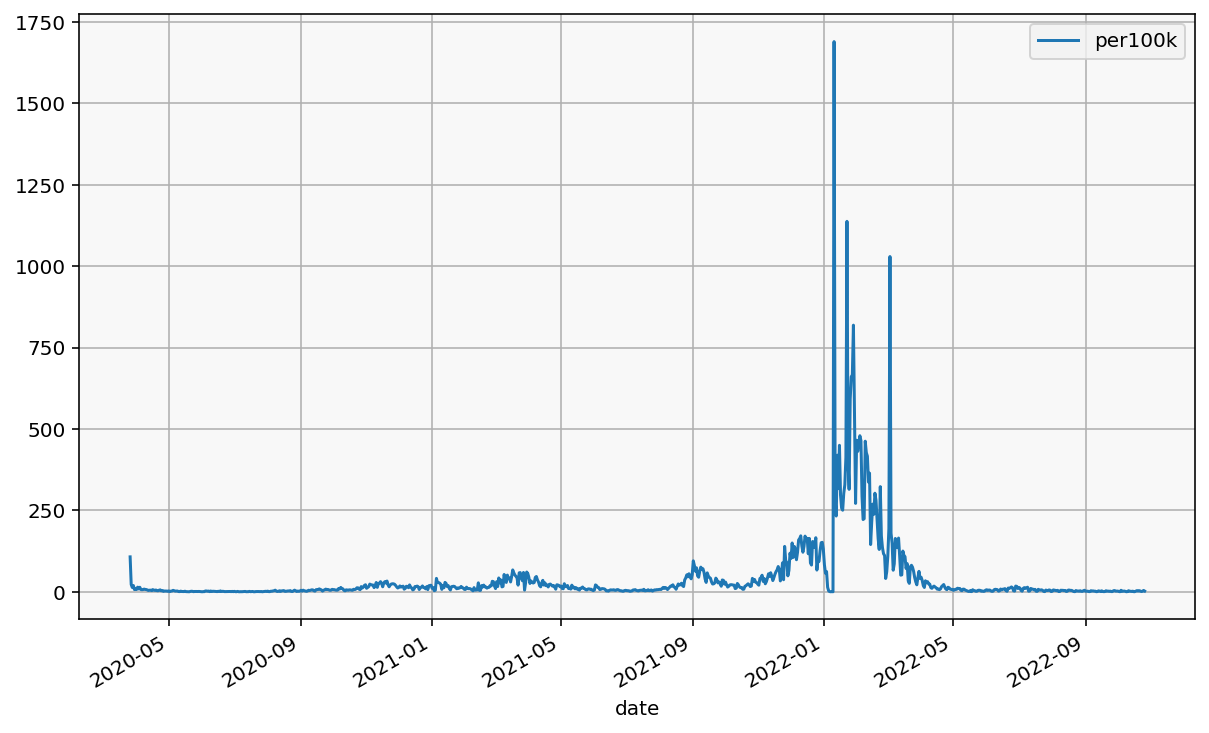

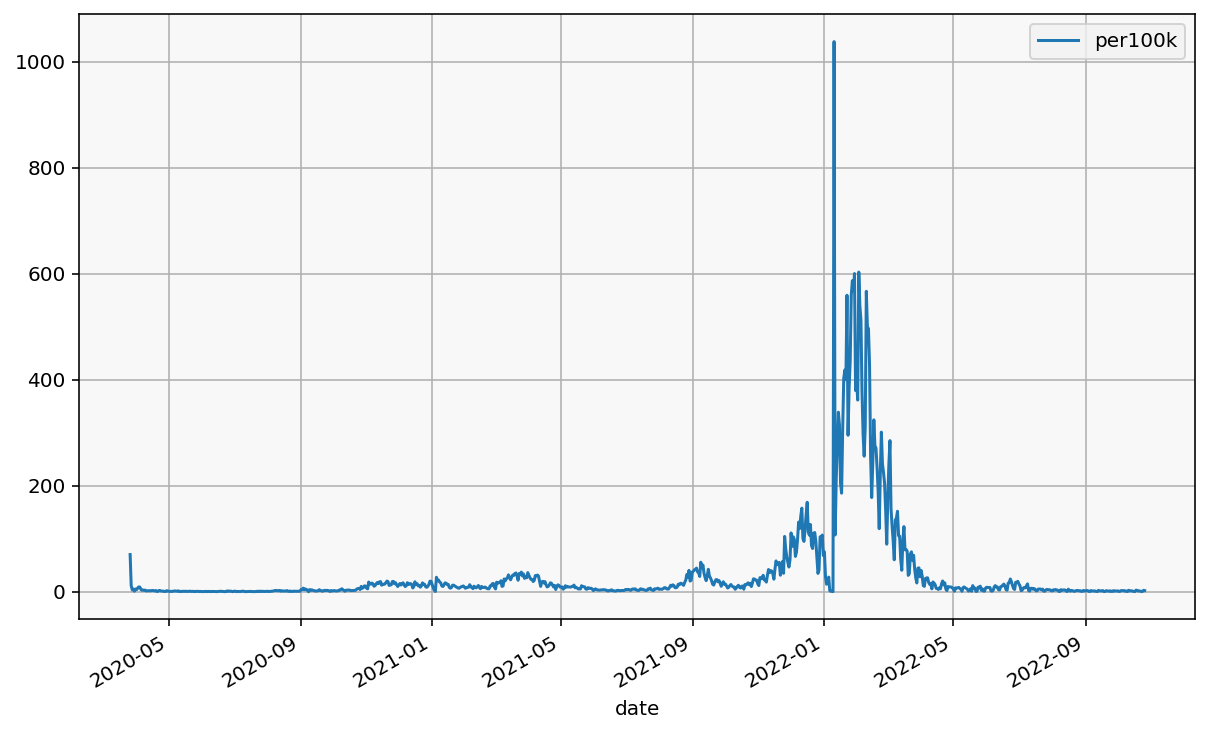

In [36]:
subset.groupby("fylke_name")[["date", "per100k"]].plot(x="date", y="per100k", legend=True)

fylke_name
Oslo     AxesSubplot(0.125,0.2;0.775x0.68)
Viken    AxesSubplot(0.125,0.2;0.775x0.68)
Name: per100k, dtype: object

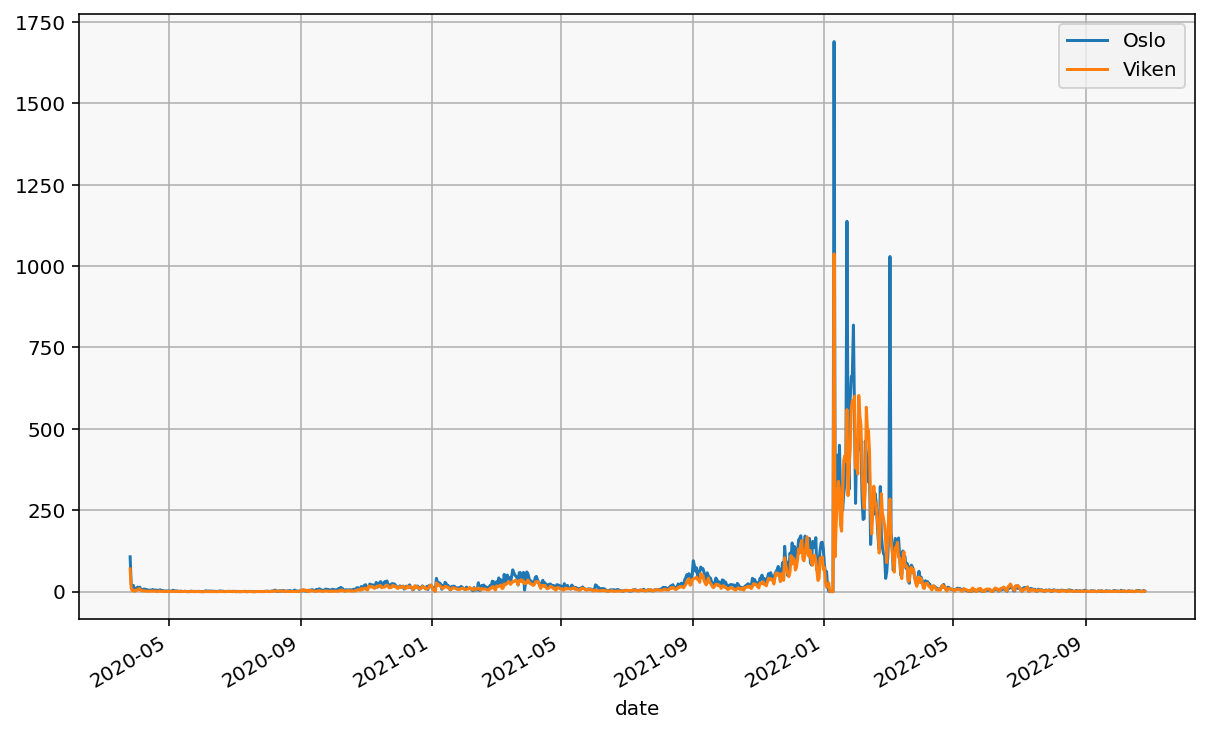

In [37]:
subset.set_index("date").groupby("fylke_name").per100k.plot(legend=True)